In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [32]:
CSV_SUPERFICIES = "superficie_estrellas.csv"
CSV_MUESTRAS = "muestras_amigos.csv"

In [33]:
df_superficies = pd.read_csv(CSV_SUPERFICIES)
df_muestras = pd.read_csv(CSV_MUESTRAS)

In [34]:
MEDIA = df_superficies["superficie"].mean()
DESVIO = df_superficies["superficie"].std()
MEDIA, DESVIO

(np.float64(18.83), np.float64(14.214841440259445))

In [35]:
df_muestras = df_muestras.merge(df_superficies, on="estrella", how="left")

In [36]:
df_superficies["muestra"] = "original"

In [37]:
df_total = pd.concat([df_superficies, df_muestras], ignore_index=True)
df_total

,estrella,superficie,muestra,sexo
0,1,8,original,NaN
1,2,5,original,NaN
2,3,8,original,NaN
3,4,32,original,NaN
4,5,21,original,NaN
...,...,...,...,...
205,65,35,2 dados 20 caras,NaN
206,40,10,2 dados 20 caras,NaN
207,33,40,2 dados 20 caras,NaN
208,63,9,2 dados 20 caras,NaN


In [38]:
df_masculino = df_total[df_total["sexo"] == "M"]
df_masculino["muestra"] = "masculino"
df_femenino = df_total[df_total["sexo"] == "F"]
df_femenino["muestra"] = "femenino"

df_total = pd.concat([df_total, df_masculino, df_femenino], ignore_index=True)

In [39]:
df_humanos = df_muestras.copy()
df_humanos["muestra"] = "humanos"

df_total = pd.concat([df_total, df_humanos], ignore_index=True)

In [40]:
dfs_aleatorias = []

for i in range(1, 5):
    df_tmp = df_superficies.sample(n=10, replace=False).copy()
    df_tmp["muestra"] = f"aleatoria {i}"
    dfs_aleatorias.append(df_tmp)

df_total = pd.concat([df_total] + dfs_aleatorias, ignore_index=True)

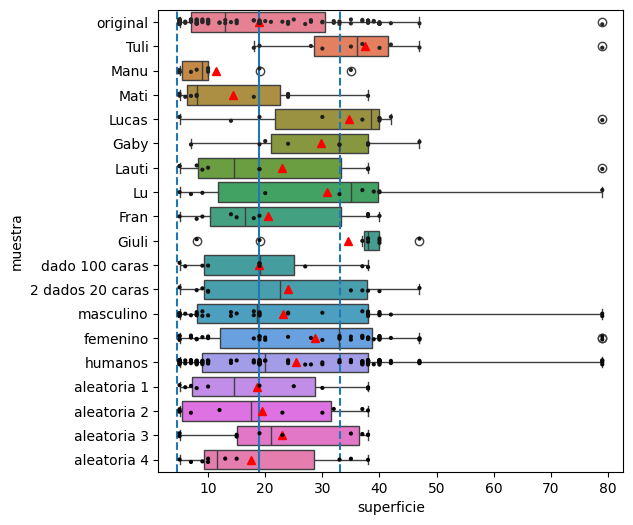

In [57]:
plt.figure(figsize=(6,6))

sns.boxplot(data=df_total, x="superficie", y="muestra", hue="muestra", orient="h", showmeans=True, meanprops={"markerfacecolor": "red", "markeredgecolor": "red"})
sns.stripplot(data=df_total, x="superficie", y="muestra", hue="muestra", orient="h", size=3, palette='dark:black')

# lineas de comparación
plt.axvline(MEDIA)
plt.axvline(MEDIA - DESVIO, linestyle="--")
plt.axvline(MEDIA + DESVIO, linestyle="--")

plt.show()

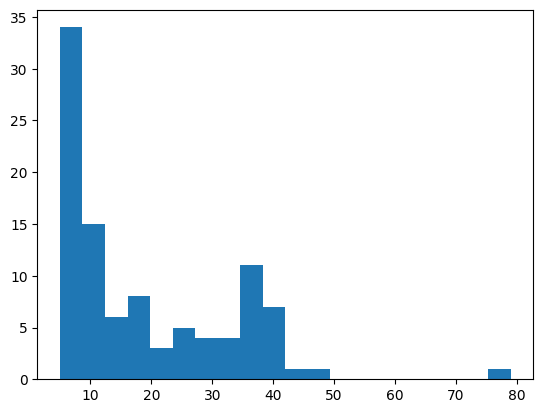

In [42]:
plt.figure()
plt.hist(df_superficies["superficie"], bins=20)
plt.show()

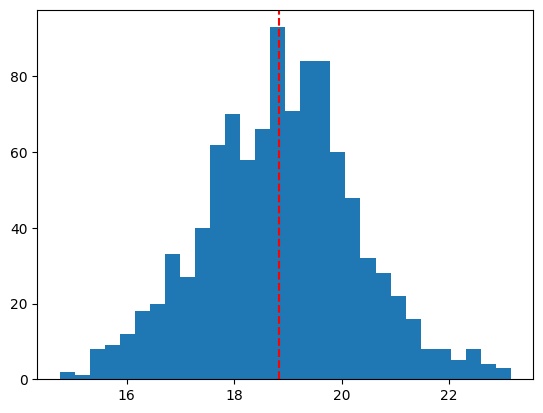

In [43]:
datos = df_superficies["superficie"]

n_boot = 1000
medias_boot = []

for _ in range(n_boot):
    muestra = np.random.choice(datos, size=len(datos), replace=True)
    medias_boot.append(muestra.mean())

medias_boot = np.array(medias_boot)

plt.figure()
plt.hist(medias_boot, bins=30)
plt.axvline(MEDIA, linestyle="--", color="red")
plt.show()

In [44]:
# from matplotlib.animation import FuncAnimation, PillowWriter

# datos = df_superficies["superficie"]

# medias_boot = []

# fig, ax = plt.subplots()

# def update(frame):
#     ax.clear()
    
#     for _ in range(20):
#         muestra = np.random.choice(datos, size=len(datos), replace=True)
#         medias_boot.append(muestra.mean())
    
#     ax.hist(medias_boot, bins=30)
#     ax.axvline(MEDIA, linestyle="--", color="red")
#     ax.set_title(f"Bootstrap de la media ({len(medias_boot)} muestras)")

# ani = FuncAnimation(fig, update, frames=50)

# ani.save("images/bootstrap.gif", writer=PillowWriter(fps=5))